In [256]:
import numpy as np
from scipy.sparse import diags
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

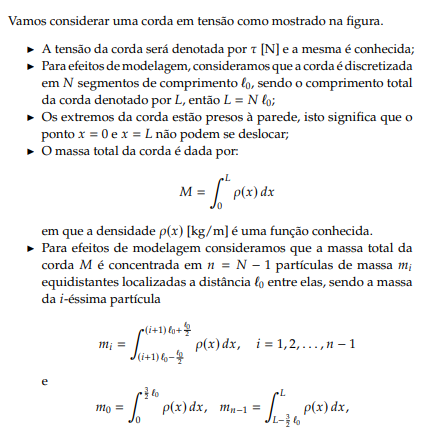

In [257]:
def particionar(N, L, rho, dx): #N subintervalos #L tamanho da corda # rho(x) função densidade
    l_0 = L/N #tamanho do subintervalo
    rho = np.vectorize(rho) #vetorizando a função
    x = np.array([]) #coordenadas das N-1 partículas
    m = np.array([]) #massa das particulas
    
    #definir a função o comrimento da corda de forma numérica
    x_num = np.arange(0, L, dx) #intervalos dx entre cada ponto
    dm = dx*rho(x_num) #pequenas variações de massa
    
    for i in range(N-1):
        if i == 0:
            x_i = l_0
            m_i = np.sum(dm[0:int(3*l_0/2 * 1/dx)]) #integrar até o mais próximo possível de 3*l_0/2
        elif i == (N-2):
            x_i = x[-1] + l_0
            m_i = np.sum(dm[int((x_i- l_0/2) * 1/dx):]) #integrar até o final da corda
            
        else:
            x_i = x[-1] + l_0
            m_i = np.sum(dm[int((x_i- l_0/2) * 1/dx) : int((x_i+ l_0/2) * 1/dx)]) #integrar ao redor do ponto da massa
            
        x = np.append(x, np.array([x_i]))
        m = np.append(m, np.array([m_i]))
        
    return x, m

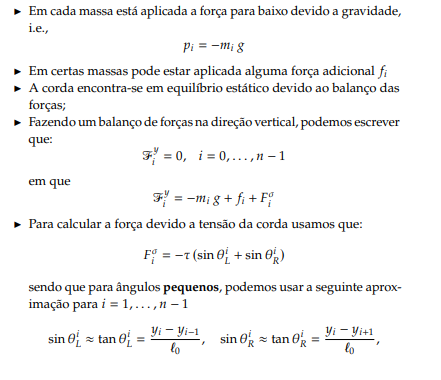

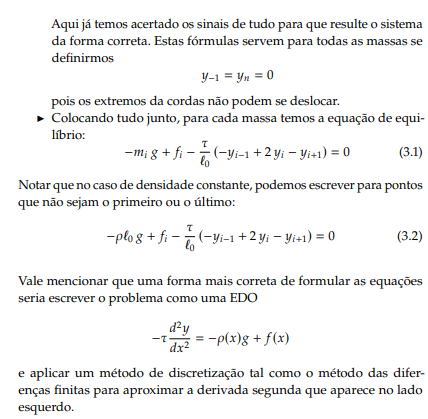

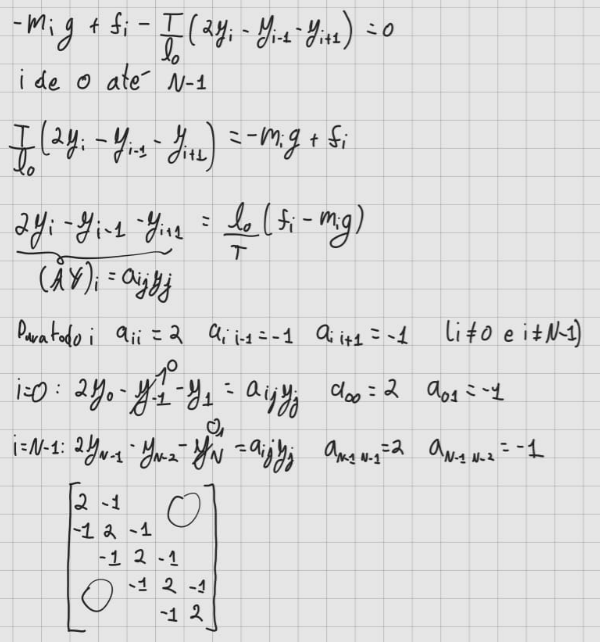

In [258]:
#montar equacoes

def equacoes(x, m, f, T):
    #Define alguns parâmetros
    l_0 = x[1] - x[0]
    N = len(x)
    g =9.8

    #AY = B
    diagonals = [2*np.ones(N), -np.ones(N-1),-np.ones(N-1) ] #diagonais da matriz A
    A = diags(diagonals, [0, -1, 1]).toarray()
 
    B = l_0/T *(f - m*g) #matrix B

    return A, B


In [259]:
def jacobi(A, B, n, epsilon): #Anxn, Bnx1, epsilon --> erro máximo adimitido 
    X = np.ones(shape=n)
    delta = np.inf
    
    D = np.diag(np.diag(A))
    L = np.tril(A) -D
    U = np.triu(A) -D
    
    m_inv = np.linalg.inv(D)
    soma = L+U

    while delta > epsilon:
        X_new = m_inv @ (B - soma@X) #iteração na forma matricial
        delta = np.max(np.abs(X_new - X))
        X = X_new
        
    return X

def main_jacobi(N, L, rho, T, f): #aplica todas as funções
    x, m = particionar(N, L, rho, 1e-7)
    A, B = equacoes(x, m, f, T)
    Y = jacobi(A, B, N-1, 1e-8)
    return x, Y
    

In [260]:
def gauss_seidel(A, B, n, epsilon):
    X = np.ones(shape=n)
    delta = np.inf
    
    D = np.diag(np.diag(A))
    L = np.tril(A) -D
    U = np.triu(A) -D

    m_inv = np.linalg.inv(D+L)
    
    while delta > epsilon:
        X_new = m_inv @ (-(U @ X) +B) #modificação com respeito ao método de jacobi --> seguindo equações da wikipedia
        delta = np.max(np.abs(X_new - X))
        X = X_new
        
    return X

def main_gauss_seidel(N, L, rho, T, f): #aplica todas as funções
    x, m = particionar(N, L, rho, 1e-7)
    A, B = equacoes(x, m, f, T)
    Y = gauss_seidel(A, B, N-1, 1e-8)
    return x, Y

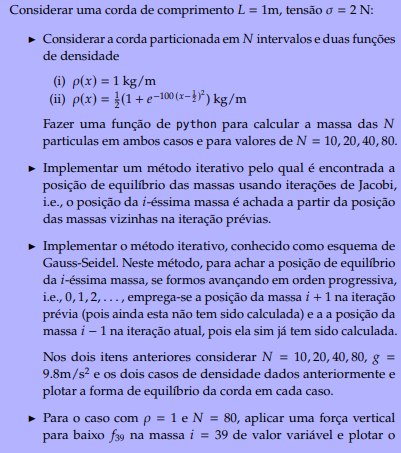

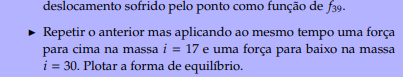

In [ ]:
def plot(X,Y, title, limitado = True): #plota o gráfico da resolução
    plt.clf()

    #adiciona os pontos (0,0) e (1,0) da condição de contorno
    X = np.append(np.array([0]), X)
    X = np.append(X, np.array([1]))

    Y = np.append(np.array([0]), Y)
    Y = np.append(Y,np.array([0]))

    #faz o plot
    plt.plot(X, Y, marker = 'o', ms = 5)
    plt.xlabel("$x \ (m)$")
    plt.ylabel("$y \ (m)$")
 
    if limitado: # para visualizar em escala, limitam-se os eixos
        plt.xlim(0,1)
        plt.ylim(-0.7, 0.3)

    plt.title(title)
    plt.savefig(f"./corda-plot/{title}.png") #salva gráfico na pasta

In [262]:
def analise():
    N_list = [10,20,40,80]
    L = 1
    T = 2

    #define as duas densidades pedidas
    rho_1 = lambda x: 1
    rho_2 = lambda x: (1/2)*(1+np.exp(-100*(x-0.5)**2))

    for N in N_list:
        f = np.zeros(N-1) #não há forças externas além da gravidade

        #resolve para a primeira densidade
        X_1, Y_1_jacobi = main_jacobi(N, L, rho_1, T, f)
        plot(X_1, Y_1_jacobi, f"N_{N}-rho_1-jacobi")
        X_1, Y_1_gauss =  main_gauss_seidel(N,L,rho_1,T, f )
        plot(X_1, Y_1_gauss, f"N_{N}-rho_1-gauss")

        #resolve para a segunda densidade
        X_2, Y_2_jacobi = main_jacobi(N, L, rho_2, T, f)
        plot(X_2, Y_2_jacobi, f"N_{N}-rho_2-jacobi")
        X_2, Y_2_gauss =  main_gauss_seidel(N,L,rho_2,T, f )
        plot(X_2, Y_2_gauss, f"N_{N}-rho_2-gauss")

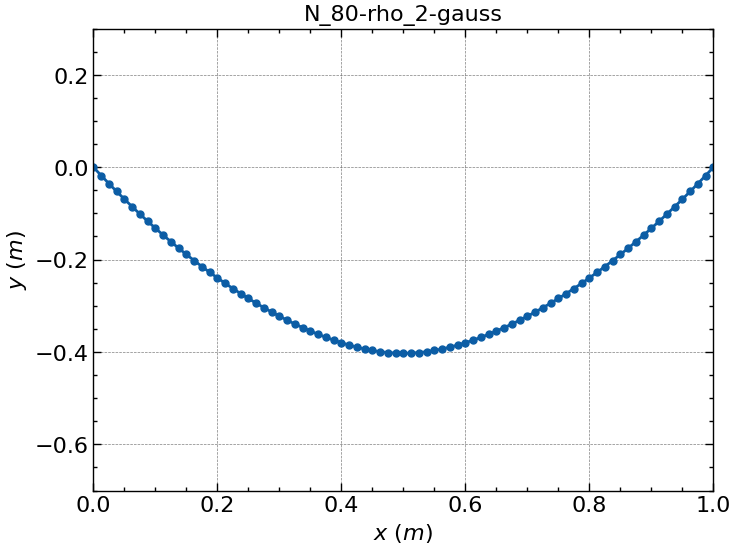

In [263]:
analise()

In [ ]:
def f_39():
    #define parâmetros iniciais
    N= 80
    L = 1
    T = 2
    rho = lambda x: 1

    #define as forças a serem consideradas
    f = np.zeros(N-1)  
    f39_list = -np.arange(0,4, 0.1)
    y39_list = [] #y_39 para cada f_39 considerado

    for i in f39_list:
        f[38] = i
        X, Y =  main_gauss_seidel(N,L,rho,T, f) #resolve o sistema para cada força
        y39_list.append(Y[39]) #adiciona na lista de soluções
    
    return f39_list, y39_list

In [ ]:
x_data, y_data = f_39() #executa todas as iterações para encontrar os dados para plot

Text(0.5, 1.0, 'Deslocamento do ponto em função da força externa f no ponto')

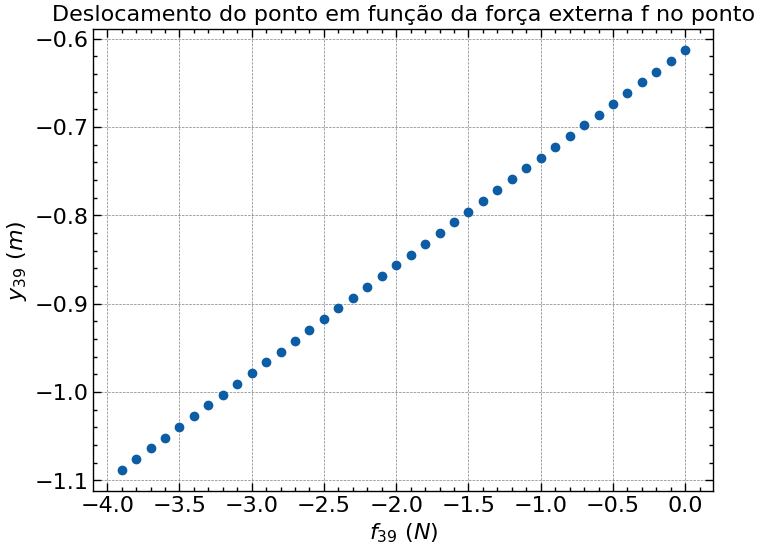

In [ ]:
plt.plot(x_data, y_data, marker = 'o', ls = '') #faz o plot do gráfico pedido
plt.xlabel("$f_{39} \ (N)$")
plt.ylabel("$y_{39} \ (m)$")
plt.title("Deslocamento do ponto em função da força externa f no ponto")

In [ ]:
def eq_f(f_17, f_30):
    #define parâmetros básicos
    N= 80
    L = 1
    T = 2
    rho = lambda x: 1
    
    #define a força externa pedida
    f = np.zeros(N-1)  
    f[16] = f_17
    f[29] = f_30

    #Resolve e plota o sistema
    X, Y =  main_gauss_seidel(N,L,rho,T, f) 
    plot(X= X,Y = Y, title = f"f17_{f_17}-f39_{f_30}", limitado=False)

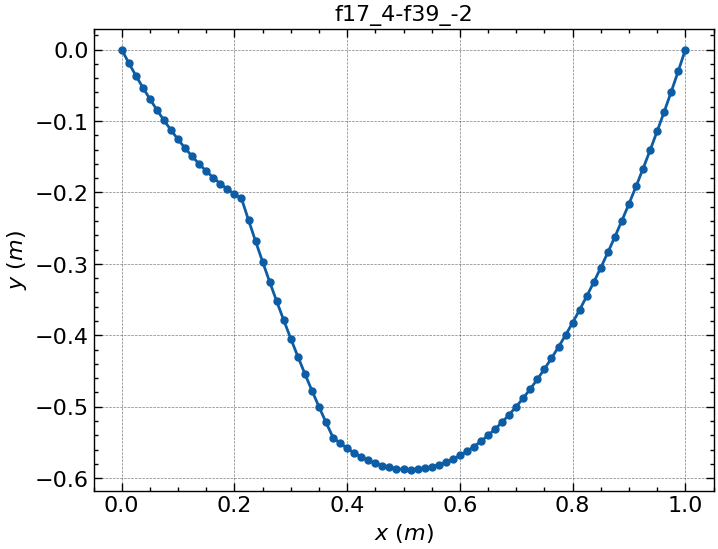

In [ ]:
f = [(0,-4),(4,0), (1,-1), (2, -2),(3, -3), (4,-4), (2,-4), (4, -2)] #pares de forças a serem considerados

for f_17, f_30 in f:
    eq_f(f_17, f_30) #resolve, faz o plot e salva para cada par